In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score, precision_recall_curve, precision_score

In [4]:
#Carreguem les taules de la base de dades (Prèviament passades a dataframe i guardades en arxiu .pickle)

demog = pd.read_pickle('C:/Users/jbakk/OneDrive/Documentos/Proyectozero/tablas/demog.pickle')
diag_dic = pd.read_csv('C:/Users/jbakk/OneDrive/Documentos/Proyectozero/tablas/diag_dic.csv', delimiter=';')
diag_events = pd.read_pickle('C:/Users/jbakk/OneDrive/Documentos/Proyectozero/tablas/diag_events.pickle')
k_anon_set = pd.read_pickle('C:/Users/jbakk/OneDrive/Documentos/Proyectozero/tablas/k_anon_set.pickle')
lab_events = pd.read_pickle('C:/Users/jbakk/OneDrive/Documentos/Proyectozero/tablas/lab_events.pickle')
monitor_dic = pd.read_pickle('C:/Users/jbakk/OneDrive/Documentos/Proyectozero/tablas/monitor_dic.pickle')
monitor_events = pd.read_pickle('C:/Users/jbakk/OneDrive/Documentos/Proyectozero/tablas/monitor_events.pickle')
ward_stay_events = pd.read_pickle('C:/Users/jbakk/OneDrive/Documentos/Proyectozero/tablas/ward_stay_events.pickle')

### REGRESSIÓ LOGÍSTICA - PREPROCESSAT

ITEM 2 (Frecuencia cardíaca ECG)

In [5]:
# Filtrar els registres per al m_item_id específic
filtered_data = monitor_events[monitor_events['m_item_id'] == 2]

# Ordenar les dades per 'patient_id' i 'm_events_datetime'
filtered_data = filtered_data.sort_values(by=['patient_id', 'm_events_datetime'])

# Calcular la diferència de temps entre registres consecutius per a cada pacient
filtered_data['time_diff'] = filtered_data.groupby('patient_id')['m_events_datetime'].diff()
filtered_data['time_diff_in_seconds'] = filtered_data['time_diff'].dt.total_seconds()

# Funció per trobar seqüències de com a mínim 30 registres consecutius amb diferència de 5 minuts
def find_sequences(data, time_diff_threshold=300, min_consecutive=30):
    result = []
    for patient_id, group in data.groupby('patient_id'):
        count = 0
        temp_sequence = []
        last_valid_sequence = []
        for i in range(1, len(group)):
            if abs(group.iloc[i]['time_diff_in_seconds'] - time_diff_threshold) <= 6:
                temp_sequence.append(group.iloc[i])
                count += 1
            else:
                if count >= min_consecutive:
                    last_valid_sequence = temp_sequence[:]
                count = 0
                temp_sequence = []
            if count >= min_consecutive:
                last_valid_sequence = temp_sequence[:]
        if count >= min_consecutive:
            last_valid_sequence = temp_sequence[:]
        result.extend(last_valid_sequence)
    return pd.DataFrame(result)

# Trobar les seqüències
consecutive_sequences = find_sequences(filtered_data)

# Unir amb la taula ward_stay_events_table per obtenir dates d'admissió i alta
consecutive_sequences = consecutive_sequences.merge(
    ward_stay_events[['patient_id', 'hosp_stay_id', 'ward_stay_id', 'ward_adm_date', 'ward_disch_date', 'ward_stay_seq_num', 'to_icu']],
    on=['patient_id', 'hosp_stay_id', 'ward_stay_id'],
    how='left'
)

# Filtrar els registres perquè estiguin dins de l'interval d'admissió i d'alta del pacient
consecutive_sequences = consecutive_sequences[
    (consecutive_sequences['m_events_datetime'] >= consecutive_sequences['ward_adm_date']) &
    (consecutive_sequences['m_events_datetime'] <= consecutive_sequences['ward_disch_date'])
]

# Assegurar eliminar duplicats
consecutive_sequences = consecutive_sequences.drop_duplicates()

# Obtenir els valors i convertir a format sol·licitat
patient_sequences = consecutive_sequences.groupby('patient_id').agg({
    'to_icu': 'first',
    'value': lambda x: list(x)
}).reset_index()

# Limitar el nombre de valors a 30 i emplenar amb NaN si n'hi ha menys de 30
def pad_or_truncate(lst, target_len=30):  # 30 valors, ja que la primera columna serà 'to_icu'
    if len(lst) > target_len:
        return lst[:target_len]
    return lst + [None] * (target_len - len(lst))

patient_sequences['value'] = patient_sequences['value'].apply(pad_or_truncate)

# Crear un DataFrame on cada columna sigui un valor consecutiu de 'value'
max_values = 30  # Limitar a 30 valores
value_columns = pd.DataFrame(patient_sequences['value'].to_list(), columns=[f'value_{i+1}' for i in range(max_values)])

# Combinar les columnes amb els resultats
final_df = pd.concat([patient_sequences[['patient_id', 'to_icu']], value_columns], axis=1)

# Especificar la ruta del fitxer on es desarà el CSV
ruta_archivo = 'C:/Users/jbakk/OneDrive/Documentos/Proyectozero/dataset_ecg.csv'

# Desar el DataFrame en un fitxer CSV a la ruta especificada
final_df.to_csv(ruta_archivo, index=False)

print(f'Registres guardats a: {ruta_archivo}')

Registres guardats a: C:/Users/jbakk/OneDrive/Documentos/Proyectozero/dataset_ecg.csv


ITEM 9 (Pulsioximetria)

In [6]:
# Filtrar els registres per al m_item_id específic
filtered_data = monitor_events[monitor_events['m_item_id'] == 9]

# Ordenar les dades per 'patient_id' i 'm_events_datetime'
filtered_data = filtered_data.sort_values(by=['patient_id', 'm_events_datetime'])

# Calcular la diferència de temps entre registres consecutius per a cada pacient
filtered_data['time_diff'] = filtered_data.groupby('patient_id')['m_events_datetime'].diff()
filtered_data['time_diff_in_seconds'] = filtered_data['time_diff'].dt.total_seconds()

# Funció per trobar seqüències de com a mínim 30 registres consecutius amb diferència de 5 minuts
def find_sequences(data, time_diff_threshold=300, min_consecutive=30):
    result = []
    for patient_id, group in data.groupby('patient_id'):
        count = 0
        temp_sequence = []
        last_valid_sequence = []
        for i in range(1, len(group)):
            if abs(group.iloc[i]['time_diff_in_seconds'] - time_diff_threshold) <= 6:
                temp_sequence.append(group.iloc[i])
                count += 1
            else:
                if count >= min_consecutive:
                    last_valid_sequence = temp_sequence[:]
                count = 0
                temp_sequence = []
            if count >= min_consecutive:
                last_valid_sequence = temp_sequence[:]
        if count >= min_consecutive:
            last_valid_sequence = temp_sequence[:]
        result.extend(last_valid_sequence)
    return pd.DataFrame(result)

# Trobar les seqüències
consecutive_sequences = find_sequences(filtered_data)

# Unir amb la taula ward_stay_events_table per obtenir dates d'admissió i alta
consecutive_sequences = consecutive_sequences.merge(
    ward_stay_events[['patient_id', 'hosp_stay_id', 'ward_stay_id', 'ward_adm_date', 'ward_disch_date', 'ward_stay_seq_num', 'to_icu']],
    on=['patient_id', 'hosp_stay_id', 'ward_stay_id'],
    how='left'
)

# Filtrar els registres perquè estiguin dins de l'interval d'admissió i d'alta del pacient
consecutive_sequences = consecutive_sequences[
    (consecutive_sequences['m_events_datetime'] >= consecutive_sequences['ward_adm_date']) &
    (consecutive_sequences['m_events_datetime'] <= consecutive_sequences['ward_disch_date'])
]

# Assegurar eliminar duplicats
consecutive_sequences = consecutive_sequences.drop_duplicates()

# Obtenir els valors i convertir a format sol·licitat
patient_sequences = consecutive_sequences.groupby('patient_id').agg({
    'to_icu': 'first',
    'value': lambda x: list(x)
}).reset_index()

# Limitar el nombre de valors a 30 i emplenar amb NaN si n'hi ha menys de 30
def pad_or_truncate(lst, target_len=30):  # 30 valors, ja que la primera columna serà 'to_icu'
    if len(lst) > target_len:
        return lst[:target_len]
    return lst + [None] * (target_len - len(lst))

patient_sequences['value'] = patient_sequences['value'].apply(pad_or_truncate)

# Crear un DataFrame on cada columna sigui un valor consecutiu de 'value'
max_values = 30  # Limitar a 30 valores
value_columns = pd.DataFrame(patient_sequences['value'].to_list(), columns=[f'value_{i+1}' for i in range(max_values)])

# Combinar les columnes amb els resultats
final_df = pd.concat([patient_sequences[['patient_id', 'to_icu']], value_columns], axis=1)

# Especificar la ruta del fitxer on es desarà el CSV
ruta_archivo = 'C:/Users/jbakk/OneDrive/Documentos/Proyectozero/dataset_pulsioximetria.csv'

# Desar el DataFrame en un fitxer CSV a la ruta especificada
final_df.to_csv(ruta_archivo, index=False)

print(f'Registres guardats a: {ruta_archivo}')

Registres guardats a: C:/Users/jbakk/OneDrive/Documentos/Proyectozero/dataset_pulsioximetria.csv


ITEM 8 (Pressió sanguínea)

In [7]:
# Filtrar els registres per al m_item_id específic
filtered_data = monitor_events[monitor_events['m_item_id'] == 8]

# Ordenar les dades per 'patient_id' i 'm_events_datetime'
filtered_data = filtered_data.sort_values(by=['patient_id', 'm_events_datetime'])

# Calcular la diferència de temps entre registres consecutius per a cada pacient
filtered_data['time_diff'] = filtered_data.groupby('patient_id')['m_events_datetime'].diff()
filtered_data['time_diff_in_seconds'] = filtered_data['time_diff'].dt.total_seconds()

# Funció per trobar seqüències de com a mínim 30 registres consecutius amb diferència de 5 minuts
def find_sequences(data, time_diff_threshold=300, min_consecutive=30):
    result = []
    for patient_id, group in data.groupby('patient_id'):
        count = 0
        temp_sequence = []
        last_valid_sequence = []
        for i in range(1, len(group)):
            if abs(group.iloc[i]['time_diff_in_seconds'] - time_diff_threshold) <= 6:
                temp_sequence.append(group.iloc[i])
                count += 1
            else:
                if count >= min_consecutive:
                    last_valid_sequence = temp_sequence[:]
                count = 0
                temp_sequence = []
            if count >= min_consecutive:
                last_valid_sequence = temp_sequence[:]
        if count >= min_consecutive:
            last_valid_sequence = temp_sequence[:]
        result.extend(last_valid_sequence)
    return pd.DataFrame(result)

# Trobar les seqüències
consecutive_sequences = find_sequences(filtered_data)

# Unir amb la taula ward_stay_events_table per obtenir dates d'admissió i alta
consecutive_sequences = consecutive_sequences.merge(
    ward_stay_events[['patient_id', 'hosp_stay_id', 'ward_stay_id', 'ward_adm_date', 'ward_disch_date', 'ward_stay_seq_num', 'to_icu']],
    on=['patient_id', 'hosp_stay_id', 'ward_stay_id'],
    how='left'
)

# Filtrar els registres perquè estiguin dins de l'interval d'admissió i d'alta del pacient
consecutive_sequences = consecutive_sequences[
    (consecutive_sequences['m_events_datetime'] >= consecutive_sequences['ward_adm_date']) &
    (consecutive_sequences['m_events_datetime'] <= consecutive_sequences['ward_disch_date'])
]

# Assegurar eliminar duplicats
consecutive_sequences = consecutive_sequences.drop_duplicates()

# Obtenir els valors i convertir a format sol·licitat
patient_sequences = consecutive_sequences.groupby('patient_id').agg({
    'to_icu': 'first',
    'value': lambda x: list(x)
}).reset_index()

# Limitar el nombre de valors a 30 i emplenar amb NaN si n'hi ha menys de 30
def pad_or_truncate(lst, target_len=30):  # 30 valors, ja que la primera columna serà 'to_icu'
    if len(lst) > target_len:
        return lst[:target_len]
    return lst + [None] * (target_len - len(lst))

patient_sequences['value'] = patient_sequences['value'].apply(pad_or_truncate)

# Crear un DataFrame on cada columna sigui un valor consecutiu de 'value'
max_values = 30  # Limitar a 30 valores
value_columns = pd.DataFrame(patient_sequences['value'].to_list(), columns=[f'value_{i+1}' for i in range(max_values)])

# Combinar les columnes amb els resultats
final_df = pd.concat([patient_sequences[['patient_id', 'to_icu']], value_columns], axis=1)

# Especificar la ruta del fitxer on es desarà el CSV
ruta_archivo = 'C:/Users/jbakk/OneDrive/Documentos/Proyectozero/dataset_pressio_sanguinia.csv'

# Desar el DataFrame en un fitxer CSV a la ruta especificada
final_df.to_csv(ruta_archivo, index=False)

print(f'Registres guardats a: {ruta_archivo}')

Registres guardats a: C:/Users/jbakk/OneDrive/Documentos/Proyectozero/dataset_pressio_sanguinia.csv


### REGRESSIÓ LOGÍSTICA - PROCESSAT

In [8]:
# Carregar les dades des de fitxers CSV
train_val_data = pd.read_csv("C:/Users/jbakk/OneDrive/Documentos/Proyectozero/9.csv")
test_data = pd.read_csv("C:/Users/jbakk/OneDrive/Documentos/Proyectozero/2.csv")

# Dividir les dades en característiques (X) i etiquetes (y)
X_train_val = train_val_data.drop(columns=['to_icu'])
y_train_val = train_val_data['to_icu']
X_test = test_data.drop(columns=['to_icu'])
y_test = test_data['to_icu']

# Dividir les dades en entrenament i validació (70%-30%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

# Inicialitzar el model de regressió logística
model = LogisticRegression(max_iter=100, random_state=42)

# Entrenar el model fent servir les dades d'entrenament
model.fit(X_train, y_train)

# Avaluar el model utilitzant validació creuada
cv_scores = cross_val_score(model, X_train_val, y_train_val, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Fer prediccions al conjunt de prova
y_pred = model.predict(X_test)

Cross-Validation Scores: [0.875 0.875 0.875 0.75  0.75 ]
Mean CV Accuracy: 0.825


### REGRESSIÓ LOGÍSTICA - AVALUACIÓ

C:\Users\jbakk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jbakk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jbakk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jbakk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.p

Precisió: 0.92
Recall (Sensibilitat): 0.00
F1-Score: 0.00
Test Accuracy: 0.92
Avaluació de la classificació:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        69
         1.0       0.00      0.00      0.00         6

    accuracy                           0.92        75
   macro avg       0.46      0.50      0.48        75
weighted avg       0.85      0.92      0.88        75



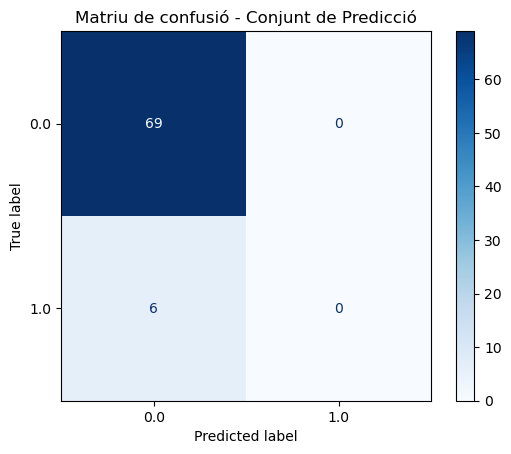

In [9]:
# Calcular la matriu de confusió
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular mètriques de rendiment
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir les mètriques calculades
print(f'Precisió: {accuracy:.2f}')
print(f'Recall (Sensibilitat): {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

# Avaluar el model al conjunt de prova
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
report = classification_report(y_test, y_pred)
print('Avaluació de la classificació:')
print(report)

# Visualitzar la matriu de confusió
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriu de confusió - Conjunt de Predicció')
plt.show()